# Create COT, Detection, and Rewriting Tuning Datasets

In [11]:
import json

with open("prompts/lamp_cot_input.txt", "r") as f:
    lamp_cot_input_prompt = f.read()

with open("prompts/lamp_cot_output.txt", "r") as f:
    lamp_cot_output_prompt = f.read()

with open("prompts/lamp_detection_input.txt", "r") as f:
    lamp_detection_input_prompt = f.read()

with open("prompts/lamp_rewriting_input.txt", "r") as f:
    lamp_rewriting_input_prompt = f.read()

def prepare_cot_sample(sample):
    input_text = lamp_cot_input_prompt.replace("[[INPUT_PARAGRAPH]]", sample["preedit"])

    problematic_spans_STR = """"""
    for i, edit in enumerate(sample["fine_grained_edits"]):
        problematic_spans_STR += f"Span {i+1}: `{edit['originalText']}` (Category: `{edit['categorization']}`)\n"

    proposed_rewriting_STR = """"""
    for i, edit in enumerate(sample["fine_grained_edits"]):
        proposed_rewriting_STR += f"Span {i+1}: `{edit['originalText']}` -> `{edit['editedText']}`\n"

    output_text = lamp_cot_output_prompt.replace("[[PROBLEMATIC_SPANS]]", problematic_spans_STR).replace("[[PROPOSED_REWRITING]]", proposed_rewriting_STR).replace("[[FINAL_PARAGRAPH]]", sample["postedit"])
    return {"id": sample["id"], "input_text": input_text, "output_text": output_text}

def prepare_detection_sample(sample):
    input_text = lamp_detection_input_prompt.replace("[[INPUT_PARAGRAPH]]", sample["preedit"])
    output_text = json.dumps({"edits": [{"span": edit["originalText"], "category": edit["categorization"]} for edit in sample["fine_grained_edits"]]})
    return {"id": sample["id"], "input_text": input_text, "output_text": output_text}

def prepare_rewriting_samples(sample):
    samples = []
    for edit_idx, edit in enumerate(sample["fine_grained_edits"]):
        input_text = lamp_rewriting_input_prompt.replace("[[INPUT_PARAGRAPH]]", sample["preedit"]).replace("[[PROBLEMATIC_SPAN]]", edit["originalText"]).replace("[[PROBLEMATIC_CATEGORY]]", edit["categorization"])
        output_text = json.dumps({"rewrite": edit["editedText"]})
        samples.append({"id": f"{sample['id']}_edit_{edit_idx}", "input_text": input_text, "output_text": output_text})
    return samples

with open("data/LAMP-train-val-test.json", "r") as f:
    lamp_data = json.load(f)

lamp_train = [d for d in lamp_data if d["data-split"] == "train"]

with open("data/lamp_train_cot_format.json", "w") as f:
    json.dump([prepare_cot_sample(sample) for sample in lamp_train], f, indent=4)

with open("data/lamp_train_detection_format.json", "w") as f:
    json.dump([prepare_detection_sample(sample) for sample in lamp_train], f, indent=4)

lamp_rewriting_samples = []
for sample in lamp_train:
    lamp_rewriting_samples += prepare_rewriting_samples(sample)

with open("data/lamp_train_rewriting_format.json", "w") as f:
    json.dump(lamp_rewriting_samples, f, indent=4)

print("Created the three datasets.")
print(f"COT has {len(lamp_train)} samples.")
print(f"Detection has {len(lamp_train)} samples.")
print(f"Rewriting has {len(lamp_rewriting_samples)} samples.")

Created the three datasets.
COT has 1000 samples.
Detection has 1000 samples.
Rewriting has 7234 samples.


In [12]:
# load cot dataset
with open("data/lamp_train_cot_format.json", "r") as f:
    lamp_train_cot = json.load(f)

print(lamp_train_cot[0]["output_text"])


Part 1: Idenfying Problematic Spans

Span 1: `The room was dimly lit, with the soft hum of machinery filling the silence` (Category: `Awkward Word Choice and Phrasing`)
Span 2: `I sat beside Lila, squeezing her hand, as the technician swirled the wand over her belly` (Category: `Lack of Specificity and Detail`)
Span 3: `The screen flickered to life, a grainy black and white, like an ancient TV trying to find it's signal` (Category: `Unnecessary Exposition`)
Span 4: `Lila's grip tightened, and I glanced at her, finding her eyes glossy, a smile tugging at the corners of her mouth` (Category: `Poor Sentence Structure`)
Span 5: `—a future that felt both incredibly close and impossibly distant` (Category: `Unnecessary Exposition`)


Part 2: Proposing Rewriting for Problematic Spans

Span 1: `The room was dimly lit, with the soft hum of machinery filling the silence` -> `The soft hum of machinery filled the room with an unfamiliar yet gentle melody.`
Span 2: `I sat beside Lila, squeezing her

# Prepare Evaluation Benchmark

In [15]:
import json

# lamp_fn = "data/LAMP-train-val-test.json"

# with open(lamp_fn, "r") as f:
#     lamp_data = json.load(f)
# lamp_test = [d for d in lamp_data if d["data-split"] == "test"]
# instruction2lamp_sample = {sample['instruction']: sample for sample in lamp_test}

gold_prefs = "data/gold_preference_600.json"
with open(gold_prefs, "r") as f:
    gold_prefs = json.load(f)

eval_samples = []
for sample_id, gold_pref in enumerate(gold_prefs):
    sample_id = f"gold_{sample_id}"
    candidates = [
        {"id": f"{sample_id}_ai_draft", "system": "ai_draft", "text": gold_pref["AI-generated"]},
        {"id": f"{sample_id}_human_edited", "system": "human_edited", "text": gold_pref["Human-edited"]},
        {"id": f"{sample_id}_fs_edited", "system": "fs_edited", "text": gold_pref["AI-edited"]},
    ]
    sample = {"id": sample_id, "instruction": gold_pref["instruction"], "candidates": candidates}
    eval_samples.append(sample)


with open("data/lamp_editing_benchmark.json", "w") as f:
    json.dump(eval_samples, f, indent=4)


# Generate Additional Candidates

In [4]:
from utils import load_env_vars
from utils_diff import make_colored_text
import tqdm

load_env_vars()

from llms import generate, generate_json

## COT Model

In [5]:
cot_model_full_name, cot_model_short_name = "ft:gpt-4o-2024-08-06:salesforce-research:lamp-4o-cot:Aqlv1wPq", "lamp-4o-cot"

with open("data/lamp_editing_benchmark.json", "r") as f:
    eval_samples = json.load(f)

with open("prompts/lamp_cot_input.txt", "r") as f:
    lamp_cot_input_prompt = f.read()

candidate_key = f"edited_{cot_model_short_name}"

todos = [sample for sample in eval_samples if not any(candidate["system"] == candidate_key for candidate in sample["candidates"])]
for sample in tqdm.tqdm_notebook(todos):
    system2candidate = {candidate["system"]: candidate for candidate in sample["candidates"]}
    ai_draft = system2candidate["ai_draft"]["text"]

    sample_candidate_key = f"{sample['id']}_{candidate_key}"
    cot_response = generate([{"role": "user", "content": lamp_cot_input_prompt}], model=cot_model_full_name, variables={"INPUT_PARAGRAPH": ai_draft}, max_tokens=2000, step="lamp-editing-cot")
    # find the line that starts with "Part 3"
    part_3_idx = cot_response.find("Part 3")
    final_rewrite = cot_response[part_3_idx:]

    final_rewrite = "\n".join(final_rewrite.split("\n")[1:]).strip()
    # print(make_colored_text(ai_draft, final_rewrite))
    sample["candidates"].append({"id": sample_candidate_key, "system": candidate_key, "text": final_rewrite})

    with open("data/lamp_editing_benchmark.json", "w") as f:
        json.dump(eval_samples, f, indent=4)


/tmp/ipykernel_587188/3899414031.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sample in tqdm.tqdm_notebook(todos):


  0%|          | 0/132 [00:00<?, ?it/s]

# Run Detect and Rewriting Pipeline

In [7]:
detection_model, rewriting_model, system_name = "ft:gpt-4o-2024-08-06:salesforce-research:lamp-4o-detection:Aqna3sJ6", "ft:gpt-4o-2024-08-06:salesforce-research:lamp-4o-rewriting:AqpAqwih", "lamp-4o-dnr"

with open("prompts/lamp_detection_input.txt", "r") as f:
    lamp_detection_input_prompt = f.read()

with open("prompts/lamp_rewriting_input.txt", "r") as f:
    lamp_rewriting_input_prompt = f.read()

def run_dnr_pipeline(ai_draft, detection_model, rewriting_model):
    # 1. Detect
    detection_response = generate_json([{"role": "user", "content": lamp_detection_input_prompt}], model=detection_model, variables={"INPUT_PARAGRAPH": ai_draft}, step="lamp-editing-dnr-detection")

    edits = detection_response["edits"]
    filtered_edits = [edit for edit in edits if edit["span"] in ai_draft and ai_draft.count(edit["span"]) == 1]

    # 2. Rewrite
    for edit in filtered_edits:
        output_rewrite = generate_json([{"role": "user", "content": lamp_rewriting_input_prompt}], model=rewriting_model, variables={"INPUT_PARAGRAPH": ai_draft, "PROBLEMATIC_SPAN": edit["span"], "PROBLEMATIC_CATEGORY": edit["category"]}, step="lamp-editing-dnr")
        edit["rewrite"] = output_rewrite["rewrite"]

    # 3. Apply te edits
    edited_text = ai_draft
    for edit in filtered_edits:
        edited_text = edited_text.replace(edit["span"], edit["rewrite"])

    return edited_text, filtered_edits


with open("data/lamp_editing_benchmark.json", "r") as f:
    eval_samples = json.load(f)

todos = [sample for sample in eval_samples if not any(candidate["system"] == system_name for candidate in sample["candidates"])]

for sample in tqdm.tqdm_notebook(todos):
    system2candidate = {candidate["system"]: candidate for candidate in sample["candidates"]}
    ai_draft = system2candidate["ai_draft"]["text"]

    sample_candidate_key = f"{sample['id']}_{system_name}"
    edited_text, edits = run_dnr_pipeline(ai_draft, detection_model, rewriting_model)
    sample["candidates"].append({"id": sample_candidate_key, "system": system_name, "text": edited_text, "edits": edits})

    with open("data/lamp_editing_benchmark.json", "w") as f:
        json.dump(eval_samples, f, indent=4)


/tmp/ipykernel_587188/1111891830.py:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sample in tqdm.tqdm_notebook(todos):


  0%|          | 0/29 [00:00<?, ?it/s]

# Run Reward-based Scoring

In [6]:
from utils import load_env_vars
load_env_vars()
from llms import generate_json
import tqdm, json

with open("prompts/reward_calc.txt", "r") as f:
    reward_calc_prompt = f.read()

REWARD_MODEL = "ft:gpt-4o-2024-08-06:salesforce-research:lamp-4o-p:AYKM53Ac"

def calculate_reward(candidate):
    output_response = generate_json([{"role": "user", "content": reward_calc_prompt}], model=REWARD_MODEL, variables={"PARAGRAPH": candidate["text"]}, step="lamp-editing-r-eval")
    candidate["score"] = output_response["score"]
    print(candidate["id"], candidate["score"])

with open("data/lamp_editing_benchmark.json", "r") as f:
    eval_samples = json.load(f)

todos = [candidate for sample in eval_samples for candidate in sample["candidates"] if "score" not in candidate]
for i, todo in enumerate(tqdm.tqdm_notebook(todos)):
    calculate_reward(todo)

    if i%10 == 0 or i == len(todos)-1:
        with open("data/lamp_editing_benchmark.json", "w") as f:
            json.dump(eval_samples, f, indent=4)


/tmp/ipykernel_1566192/532793879.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, todo in enumerate(tqdm.tqdm_notebook(todos)):


0it [00:00, ?it/s]

# Run Pairwise Comparisons

In [5]:
from utils import load_env_vars
load_env_vars()
from llms import generate_json
import tqdm, json, itertools, time

with open("prompts/pairwise_pref.txt", "r") as f:
    pairwise_pref_prompt = f.read()

REWARD_MODEL = "ft:gpt-4o-2024-08-06:salesforce-research:lamp-4o-p:AYKM53Ac"

def calculate_pairwise_pref(candidate1, candidate2):
    pref_ab = generate_json([{"role": "user", "content": pairwise_pref_prompt}], model=REWARD_MODEL, variables={"PARAGRAPH1": candidate1["text"], "PARAGRAPH2": candidate2["text"]}, step="lamp-editing-pairwise-pref")
    pref_ba = generate_json([{"role": "user", "content": pairwise_pref_prompt}], model=REWARD_MODEL, variables={"PARAGRAPH1": candidate2["text"], "PARAGRAPH2": candidate1["text"]}, step="lamp-editing-pairwise-pref")

    if pref_ab["preference"] == "1" and pref_ba["preference"] == "2":
        return 1
    elif pref_ab["preference"] == "2" and pref_ba["preference"] == "1":
        return 2
    else:
        return 0 # inconsistent result

with open("data/lamp_editing_benchmark.json", "r") as f:
    eval_samples = json.load(f)

id2sample = {sample["id"]: sample for sample in eval_samples}

todo_pairs = []
for sample in eval_samples:
    candidates = sample["candidates"]
    pairwise_prefs = sample.get("pairwise_prefs", {})
    for c1, c2 in itertools.combinations(candidates, 2):
        if f"{c1['system']}__{c2['system']}" not in pairwise_prefs:
            todo_pairs.append((c1, c2, sample["id"]))

for i, (c1, c2, sample_id) in enumerate(tqdm.tqdm_notebook(todo_pairs)):
    sample = id2sample[sample_id]
    preference = calculate_pairwise_pref(c1, c2)
    if "pairwise_prefs" not in sample:
        sample["pairwise_prefs"] = {}
    sample["pairwise_prefs"][f"{c1['system']}__{c2['system']}"] = preference

    if i%10 == 0 or i == len(todo_pairs)-1:
        with open("data/lamp_editing_benchmark.json", "w") as f:
            json.dump(eval_samples, f, indent=4)


/tmp/ipykernel_1566192/1885601653.py:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, (c1, c2, sample_id) in enumerate(tqdm.tqdm_notebook(todo_pairs)):


0it [00:00, ?it/s]

# Print Results


In [7]:
import pandas as pd, json, numpy as np, itertools
from collections import defaultdict
from utils_elo import EloRating

elo = EloRating(initial_rating=1000)

# print(elo.get_ratings())

with open("data/lamp_editing_benchmark.json", "r") as f:
    eval_samples = json.load(f)

candidates_scored = [candidate for sample in eval_samples for candidate in sample["candidates"] if "score" in candidate]

for sample in eval_samples:
    for c1, c2 in itertools.combinations(sample["candidates"], 2):
        system1, system2 = c1["system"], c2["system"]
        pref = sample["pairwise_prefs"][f"{system1}__{system2}"]
        score = 1.0 if pref == 1 else 0.0 if pref == 2 else 0.5
        elo.update_rating(system1, system2, score)

system_scores = defaultdict(list)
for candidate in candidates_scored:
    system_scores[candidate["system"]].append(candidate["score"])

elo_scores = elo.get_ratings()

results = [{"system": system, "N": len(scores), "Elo_score": elo_scores[system], "R_score": np.mean(scores)} for system, scores in system_scores.items()]

pd.DataFrame(results).sort_values(by="Elo_score", ascending=False).round(3)

,system,N,Elo_score,R_score
1,human_edited,201,1272.249,6.512
4,lamp-4o-dnr,201,1157.464,5.881
3,edited_lamp-4o-cot,201,1084.388,5.985
2,fs_edited,201,1011.731,5.512
0,ai_draft,201,474.169,5.194


,ai_draft,fs_edited,edited_lamp-4o-cot,lamp-4o-dnr,human_edited
system1,,,,,
ai_draft,nan,0.018,0.000,0.000,0.000
fs_edited,0.982,nan,0.239,0.170,0.076
edited_lamp-4o-cot,1.000,0.761,nan,0.429,0.319
lamp-4o-dnr,1.000,0.830,0.571,nan,0.346
human_edited,1.000,0.924,0.681,0.654,nan


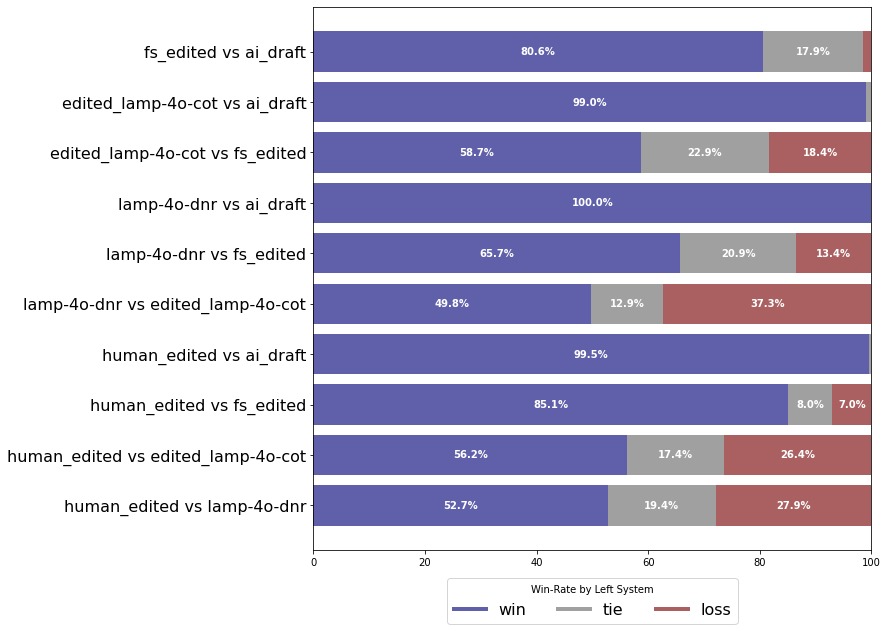

In [2]:
# Print Pairwise Win-Rates
from matplotlib import pyplot as plt
from collections import Counter

systems = set([candidate["system"] for sample in eval_samples for candidate in sample["candidates"]])

def reverse_pairwise_pref(pref):
    return 2 if pref == 1 else 1 if pref == 2 else 0

pairwise_prefs = defaultdict(list)
for sample in eval_samples:
    for c1, c2 in itertools.combinations(sample["candidates"], 2):
        if f"{c1['system']}__{c2['system']}" in sample.get("pairwise_prefs", {}):
            pairwise_prefs[(c1["system"], c2["system"])].append(sample["pairwise_prefs"][f"{c1['system']}__{c2['system']}"])
            pairwise_prefs[(c2["system"], c1["system"])].append(reverse_pairwise_pref(sample["pairwise_prefs"][f"{c1['system']}__{c2['system']}"]))

win_rates_table = []

systems = list(set([system for (system1, system2), prefs in pairwise_prefs.items() for system in [system1, system2]]))
system_avg_win_rates = {system1: np.sum([pairwise_prefs[(system1, system2)].count(1) for system2 in systems]) for system1 in systems}
# print(system_avg_win_rates)
systems = sorted(systems, key=lambda x: system_avg_win_rates[x])

for system1 in systems:
    table_row = {"system1": system1}
    for system2 in systems:
        prefs = pairwise_prefs[(system1, system2)]
        if len(prefs) == 0:
            table_row[system2] = np.nan
        else:
            pref_counts = Counter(prefs)
            # print(system1, system2, pref_counts)
            table_row[system2] = pref_counts[1] / (pref_counts[1] + pref_counts[2])
    win_rates_table.append(table_row)

display(pd.DataFrame(win_rates_table).set_index("system1").style.background_gradient(cmap="Blues", low=0.0, high=1).format("{:.3f}"))

# let's plot the full win/loss/tie distributions

all_pairs = list(itertools.combinations(systems[::-1], 2))
# we need to plot them as horizontal bars

colors = ["#6060aa", "#a0a0a0", "#aa6060"]
labels = ["win", "tie", "loss"]
lefts = [0.0] * len(all_pairs)
# create a plot with len(all_pairs) rows
plt.figure(figsize=(10, len(all_pairs)))
for cat_idx, cat in enumerate(labels):
    for row_idx, (system1, system2) in enumerate(all_pairs):
        prefs = pairwise_prefs[(system1, system2)]
        pref_counts = Counter(prefs)
        val = 1 if cat == "win" else 2 if cat == "loss" else 0

        perc = 100.0 * pref_counts[val] / sum(pref_counts.values())

        plt.barh([row_idx], [perc], color=colors[cat_idx], left=lefts[row_idx])
        if perc > 2.0:
            plt.text(lefts[row_idx]+perc/2, row_idx, f"{perc:.1f}%", color="white", ha="center", va="center", fontweight="bold")
        lefts[row_idx] += perc


y_ticks = [f"{system1} vs {system2}" for system1, system2 in all_pairs]
plt.yticks(range(len(all_pairs)), y_ticks, fontsize=16)

# put it below, centered on the x-axis
# should have a title: Win-Rate by Left System
plt.legend([plt.Line2D([0], [0], color=color, lw=4) for color in colors], labels, ncol=3, loc="lower center", bbox_to_anchor=(0.5, -0.15), fontsize=16, title="Win-Rate by Left System")
plt.show()



In [3]:
# calculate three-way consistency per sample:
def three_way_consistency(p12, p13, p23):
    p12_simple = 1 if p12 == 1 else -1 if p12 == 2 else 0
    p13_simple = 1 if p13 == 1 else -1 if p13 == 2 else 0
    p23_simple = 1 if p23 == 1 else -1 if p23 == 2 else 0
    if p12_simple * p23_simple > 0:
        return p12_simple * p13_simple > 0 and p23_simple * p13_simple > 0
    return True

consistency_scores = []
for sample in eval_samples:
    for c1, c2, c3 in itertools.combinations(sample["candidates"], 3):
        system1, system2, system3 = c1["system"], c2["system"], c3["system"]
        # check consistency 
        p12 = sample["pairwise_prefs"][f"{system1}__{system2}"]
        p13 = sample["pairwise_prefs"][f"{system1}__{system3}"]
        p23 = sample["pairwise_prefs"][f"{system2}__{system3}"]
        consistent = three_way_consistency(p12, p13, p23)
        consistency_scores.append(1 if consistent else 0)
        if not consistent:
            print("------")
            print(system1, system2, system3)
            print(f"{system1} vs. {system2}: {p12}")
            print(f"{system1} vs. {system3}: {p13}")
        # print(f"{system2} vs. {system3}: {p23}")

        # print(p12, p13, p23)

print(f"Consistency/Transitivity Score: {100.0 * np.mean(consistency_scores):.1f}%")


Consistency/Transitivity Score: 100.0%
